# NVCL Dataservices Notebook

This notebook demonstrates on how you can query NVCL Dataservices.

Webserver URL of different states:

https://nvclwebservices.csiro.au/geoserver/wfs <br/>
https://gs.geoscience.nsw.gov.au/geoserver/wfs <br/>
https://geology.information.qld.gov.au/geoserver/wfs <br/>
https://sarigdata.pir.sa.gov.au/geoserver/wfs <br/>
http://geossdi.dmp.wa.gov.au/services/wfs <br/>
https://www.mrt.tas.gov.au/web-services/wfs <br/>
http://geology.data.nt.gov.au/geoserver/wfs <br/>
http://geology.data.vic.gov.au/nvcl/wfs <br/>

In [42]:
from nvcl_kit.reader import NVCLReader 
from types import SimpleNamespace
param = SimpleNamespace()

param.WFS_URL = "https://sarigdata.pir.sa.gov.au/geoserver/wfs"

# URL of NVCL service
param.NVCL_URL = "https://sarigdata.pir.sa.gov.au/NVCLDataServices/"

reader = NVCLReader(param)

In [43]:
if not reader.wfs:
    print("ERROR!")

In [44]:
nvcl_id_list = reader.get_nvcl_id_list()

In [45]:
import xmltodict
import pandas as pd

data = []
response_str = reader.svc.get_dataset_collection('all', headersonly='yes')
dataset_obj = xmltodict.parse(response_str)["DatasetCollection"]["Dataset"]
for dataset_dict in (dataset_obj if type(dataset_obj) is list else [dataset_obj]):
    borehole_id = dataset_dict['boreholeURI'].rsplit('/', 1).pop()
    dataset_dict.update({'boreholeId':borehole_id})
    data.append(dataset_dict)

dataset_df = pd.DataFrame(data)

In [50]:
from ipyaggrid import Grid

column_defs = [
    {'field': 'boreholeId', 'headerName': 'Borehole Id', 'headerCheckboxSelection': True, 'checkboxSelection': True},
    {'field': 'DatasetID', 'headerName': 'Dataset Id'},
    {'field': 'DatasetName', 'headerName': 'Dataset Name'},
    {'field': 'boreholeURI', 'headerName': 'Borehole URI'}
]
grid_options = {
    'columnDefs' : column_defs,
    'enableSorting': True,
    'enableFilter': True,
    'enableColResize': True,
    'rowSelection': 'multiple'
}

dataset_g = Grid(grid_data=dataset_df,
    height=400,
    theme='ag-theme-balham',
    grid_options=grid_options,
    columns_fit='auto',
    quick_filter=True,
    export_mode='buttons')

dataset_g

Grid(columns_fit='auto', compress_data=True, export_mode='buttons', height='400px', menu={'buttons': [{'name':…

In [71]:
if 'rows' not in dataset_g.grid_data_out:
    raise Exception('Please select your datasets and click on export rows')
    
selected_rows_df = dataset_g.grid_data_out['rows']

In [72]:
from ipywidgets import Dropdown, Layout, HTML
from IPython.display import clear_output

dataset_dw = Dropdown(
    options = list(zip(selected_rows_df['DatasetName'], selected_rows_df['DatasetID'])),
    value = selected_rows_df['DatasetID'].values[0],
    description = 'Dataset',
    layout = Layout(margin='20px')
)

imglogs = reader.get_tray_thumb_imglogs(selected_rows_df['DatasetID'].values[0])
print (imglogs)
mosaic_html = reader.get_mosaic_image(imglogs[0].log_id)

def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    imglogs = reader.get_tray_thumb_imglogs(change['new'])
    mosaic_html = reader.get_mosaic_image(imglogs[0].log_id)
    clear_output(True)
    display(dataset_dw, HTML(value=mosaic_html))

dataset_dw.observe(on_change)

display(dataset_dw, HTML(value=mosaic_html))

Dropdown(description='Dataset', index=1, layout=Layout(margin='20px'), options=(('129520_Yalkalpo1', '0f18fe0f…

HTML(value='<!DOCTYPE HTML>\n<html>\n  <head>\n    <title>NVCL Data Services :: Mosaic Web Service</title>\n  …

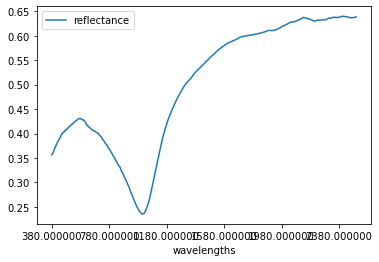

In [99]:
import xmltodict
import pandas as pd
import urllib
import array

specrtral_data_df = selected_rows_df.loc[selected_rows_df['DatasetID'] == dataset_dw.value]
response_str = reader.svc.get_dataset_collection(specrtral_data_df['boreholeId'].values[0], 
                    datasetid=specrtral_data_df['DatasetID'].values[0])
spectral_logs_obj = xmltodict.parse(response_str)['DatasetCollection']['Dataset']['SpectralLogs']['SpectralLog']

data = []
for spectral_logs_dict in (spectral_logs_obj if type(spectral_logs_obj) is list else [spectral_logs_obj]):
    data.append(spectral_logs_dict)

spectral_logs_df = pd.DataFrame(data)

reflectance_df = spectral_logs_df.loc[spectral_logs_df['logName'] == 'Reflectance']

params = {'speclogid': reflectance_df['logID'].values[0], 'endsampleno': '1', 'startsampleno': '1'}
spect_enc_params = urllib.parse.urlencode(params).encode('ascii')
spect_req = urllib.request.Request(param.NVCL_URL + '/getspectraldata.html', spect_enc_params)
with urllib.request.urlopen(spect_req, timeout=60) as response:
    U = array.array("f")
    U.fromstring(response.read(2124))
    spec_data = {'reflectance': U}
    wvl_data = {'wavelengths' : reflectance_df['wavelengths'].values[0].split(',')}
    spect_df = pd.concat([pd.DataFrame(wvl_data), pd.DataFrame(spec_data)], axis=1, sort=False)
    
spect_df.plot(kind='line', x='wavelengths', y='reflectance')